# Data

Data used for this demo can be downloaded from Kaggle: [link](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data)

It is 3 years daily sales data for a retailer, but we will be aggregating to monthly sales for this activity. 

I have tried to implement STL decomposition from scratch to propose an anomaly detection algorithm using only the residuals from the decomposition. We will be using a rolling median based technique to be add more robustness against outliers. 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [7]:
# creating a new dataframe for total unit sales from dash dataframe
# chunksize = 10 ** 7
# df = pd.DataFrame()
# for chunk in pd.read_csv('train.csv', chunksize=chunksize):
#     # grouping data to find the total unit sales per day
#     data = chunk.groupby(['date'])['date', 'unit_sales'].sum()
#     df = df.append(data)
# df.head()

In [8]:
# df.reset_index(inplace=True)
# df = df.groupby('date')['date', 'unit_sales'].sum()
# df.reset_index(inplace=True)
# converting the date dtype from object to datetime
# df['date'] = pd.to_datetime(df['date']) 
# df.to_csv("sales_data_daily.csv", index=False)

In [9]:
df = pd.read_csv("sales_data_daily.csv")
df["date"] = pd.to_datetime(df["date"])

In [10]:
## Plot function

def plot_line_chart(df, x, y, title=""):
    plt.figure(figsize=(50,10))
    plt.rcParams.update({'font.size': 22})
    plt.grid()
    plt.plot(df[x], df[y], marker='', linestyle='-')
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

/Users/siddheshpisal/.pyenv/versions/3.6.7/envs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


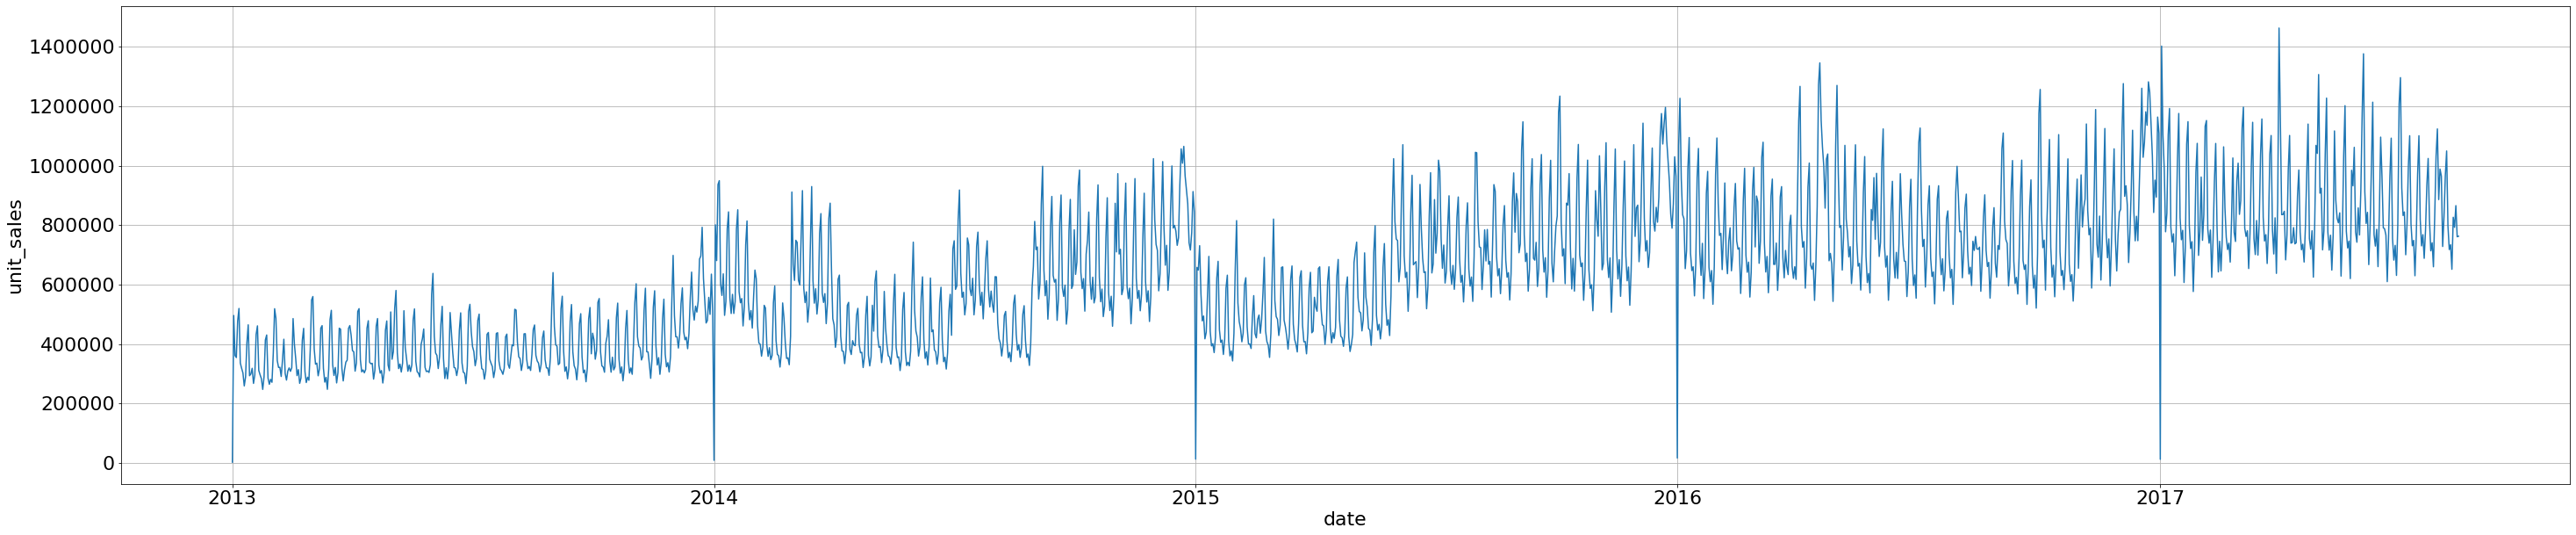

In [11]:
plot_line_chart(df, "date", "unit_sales")

In [12]:
data = df[(df.date.astype(str) >= '2013-01-01') & (df.date.astype(str) < '2018-01-01')].reset_index(drop=True)

# splitting the date column to day, month and year
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
# grouping the data to find the total unit sales per month
data = data.groupby(['month', 'year'])['date', 'unit_sales'].sum().sort_values(by=['year','month']).reset_index()
data.rename(columns={'unit_sales':'timeseries'}, inplace=True)
df.head()

,date,unit_sales
0,2013-01-01,2511.619
1,2013-01-02,496092.418
2,2013-01-03,361429.231
3,2013-01-04,354459.677
4,2013-01-05,477350.121


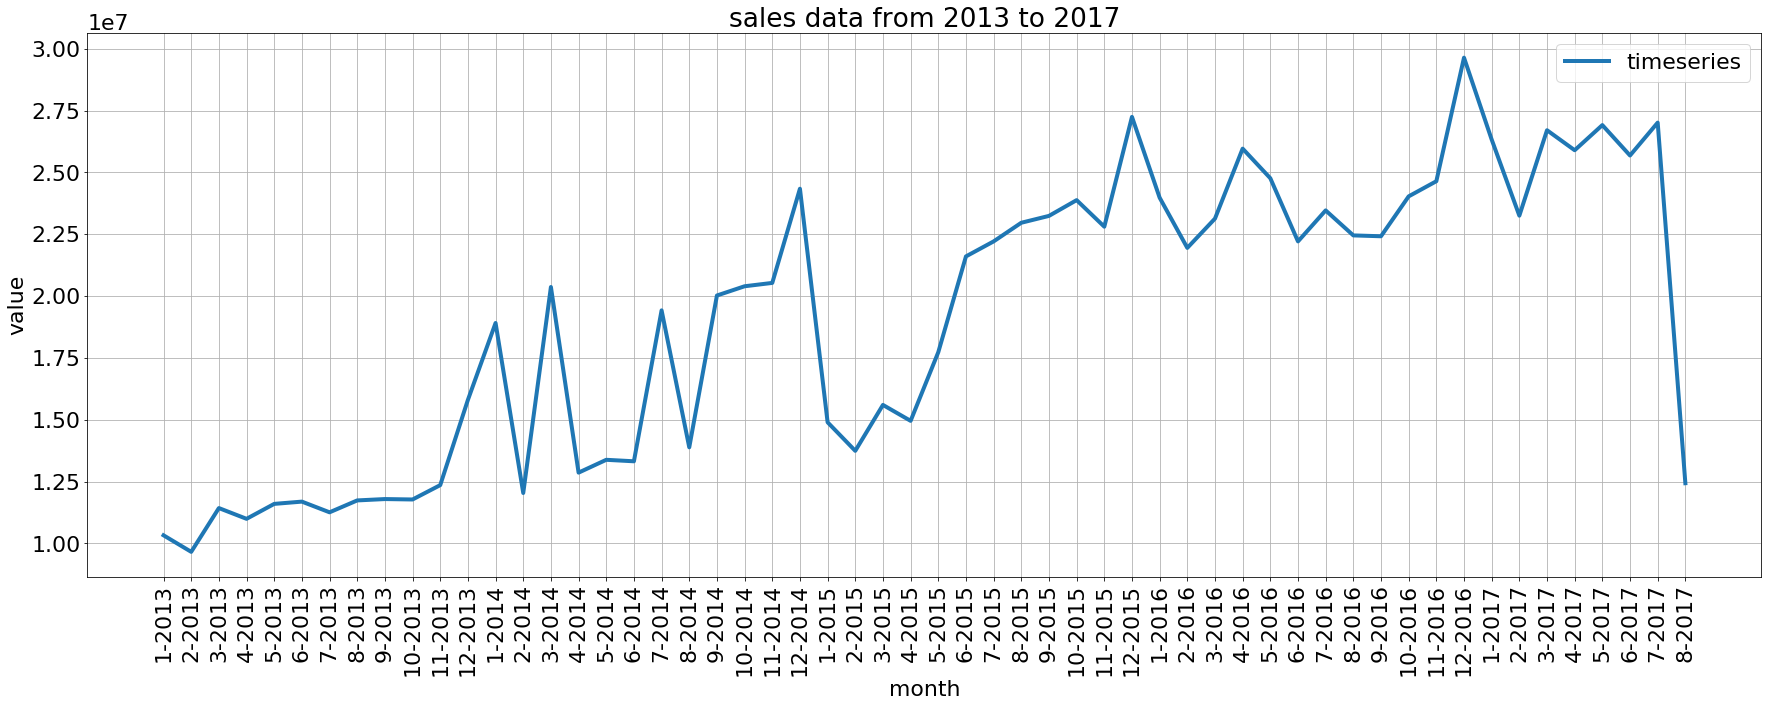

In [13]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
X_index = data['month'].astype('str') + '-' + data['year'].astype('str')
plt.plot(X_index, data.timeseries, marker='', linestyle='-', label='timeseries', linewidth=4)
plt.title("sales data from 2013 to 2017")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [14]:
# importing libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


In [15]:

# index
X = data.index.values
# timeseries value
y = data.timeseries.values

In [16]:
# scaling
scaler = MinMaxScaler()
scaler = scaler.fit(y.reshape(-1,1))
y_scaled = scaler.transform(y.reshape(-1,1))



In [17]:

# creating polynomial feature of degree 5
poly = PolynomialFeatures(5)
X_poly = poly.fit_transform(X.reshape(-1,1))


In [18]:

# fitting model
model = LinearRegression()
model = model.fit(X_poly, y_scaled)

# approx_trend 
approx_trend = model.predict(X_poly)
data['approx_trend'] = scaler.inverse_transform(approx_trend)


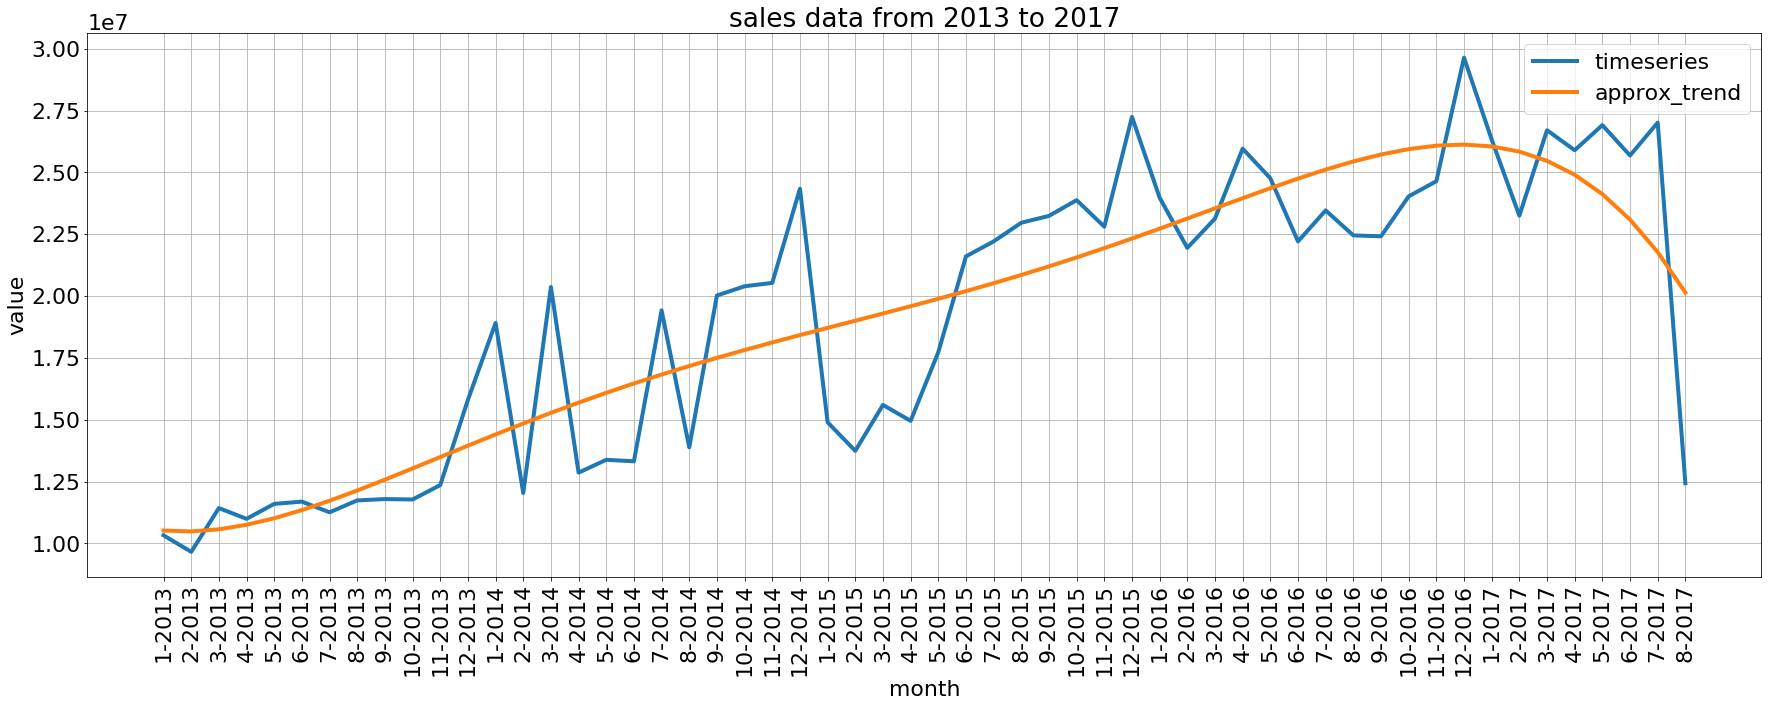

In [19]:

# plotting
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, y, marker='', linestyle='-', label='timeseries', linewidth=4)
plt.plot(X_index, data.approx_trend, marker='', linestyle='-', label='approx_trend', linewidth=4)
plt.title("sales data from 2013 to 2017")
plt.xlabel("month")
plt.ylabel("value")
plt.legend()
plt.xticks(rotation=90)
plt.show()

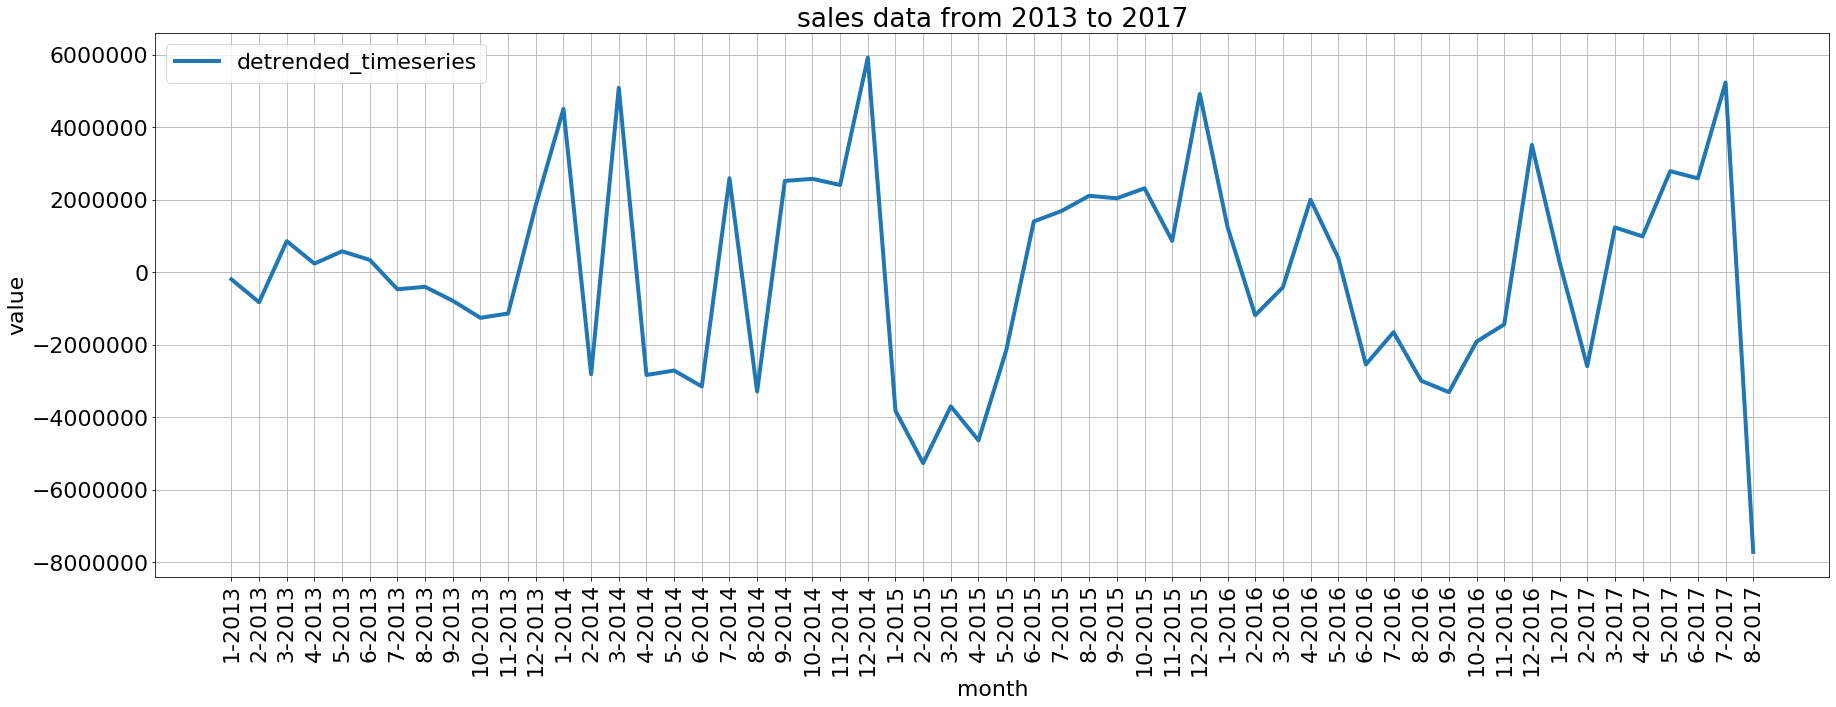

In [20]:
# Remove the trend after fitting linear model
data['detrended_series'] = data.timeseries - data.approx_trend.values

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.detrended_series, marker='', linestyle='-', label='detrended_timeseries', linewidth=4)
plt.title("sales data from 2013 to 2017")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [21]:
# find the seasonal pattern
seasonal_comp = data.groupby('month')['month', 'detrended_series'].mean().reset_index(drop=True)

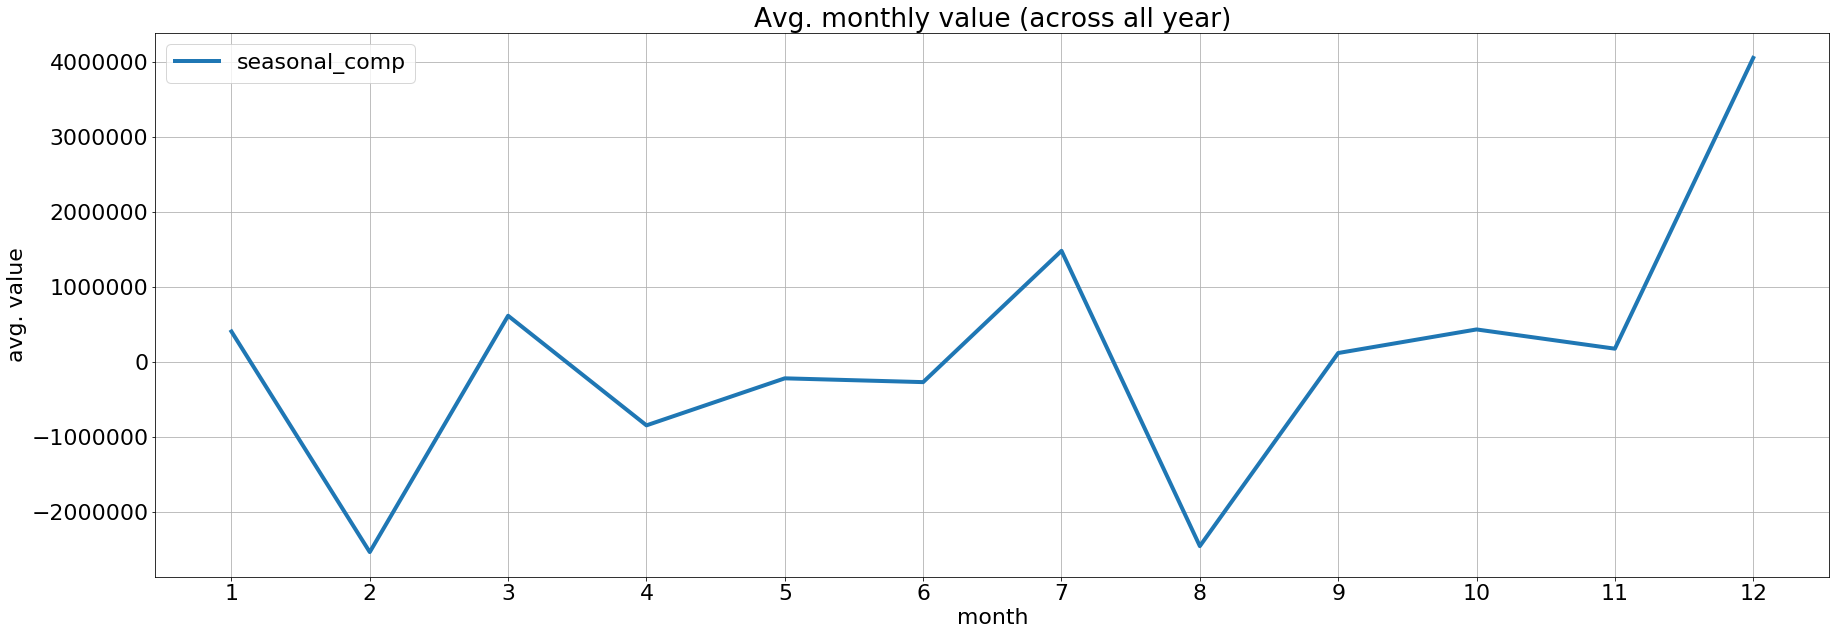

In [22]:

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(seasonal_comp.month.astype(str), seasonal_comp.detrended_series, marker='', linestyle='-', label='seasonal_comp', linewidth=4)
plt.title("Avg. monthly value (across all year)")
plt.xlabel("month")
plt.ylabel("avg. value")
plt.legend()
plt.show()

In [23]:
# replicate this seasonal component across the timeseries
seasonal = pd.DataFrame()
if data.timeseries.shape[0]%seasonal_comp.shape[0] != 0:
    diff = data.timeseries.shape[0]%seasonal_comp.shape[0]
    for i in range(int(data.timeseries.shape[0]/seasonal_comp.shape[0])):
        seasonal = pd.concat([seasonal, seasonal_comp])
    seasonal = pd.concat([seasonal, seasonal_comp[:diff]])

data['seasonal'] = seasonal.detrended_series.values

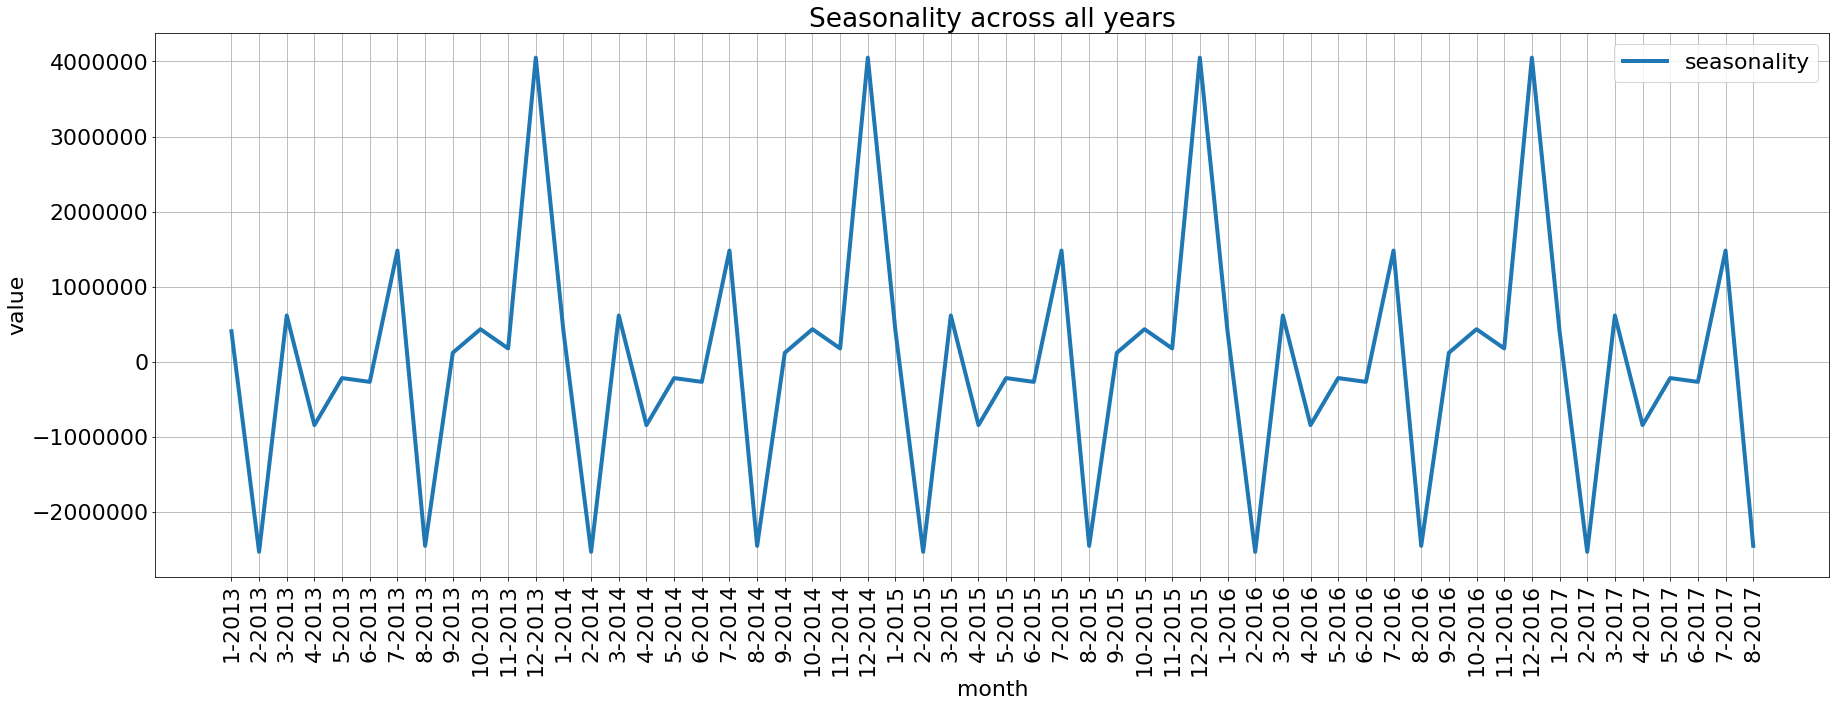

In [24]:

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.seasonal, marker='', linestyle='-', label='seasonality', linewidth=4)
plt.title("Seasonality across all years")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [26]:
# Deseasonalize
data['deseasonalised'] = data.timeseries - data.seasonal


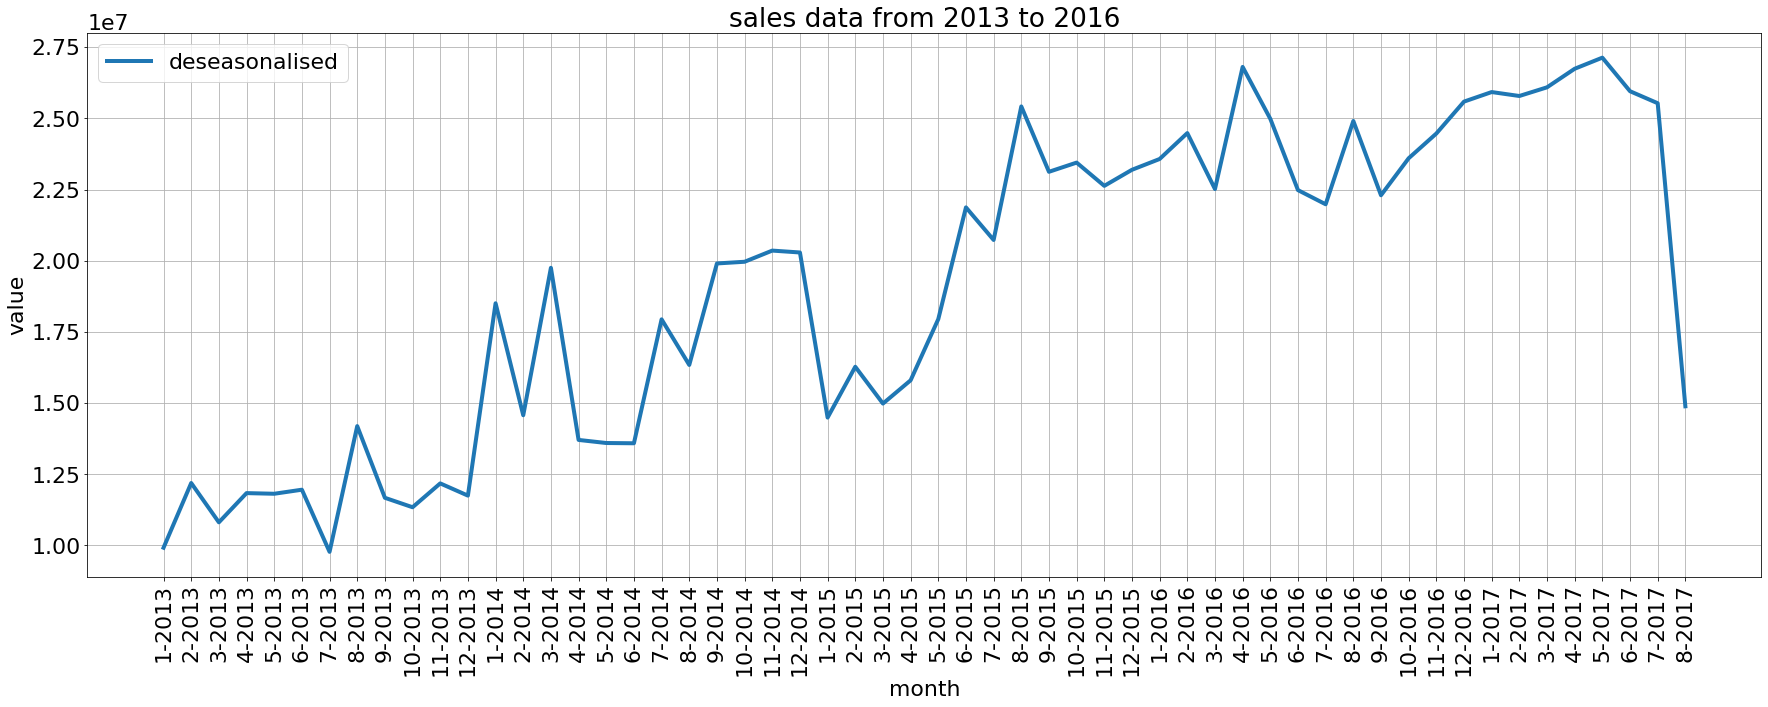

In [27]:

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.deseasonalised, marker='', linestyle='-', label='deseasonalised', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [28]:
# fitting the polynomial model with deseasonalised data
scaler = MinMaxScaler()
scaler = scaler.fit(y.reshape(-1,1))
y_scaled = scaler.transform(data.deseasonalised.values.reshape(-1,1))

model = LinearRegression()
model = model.fit(X_poly, y_scaled)

# trend
trend = model.predict(X_poly)
data['trend'] = scaler.inverse_transform(trend)


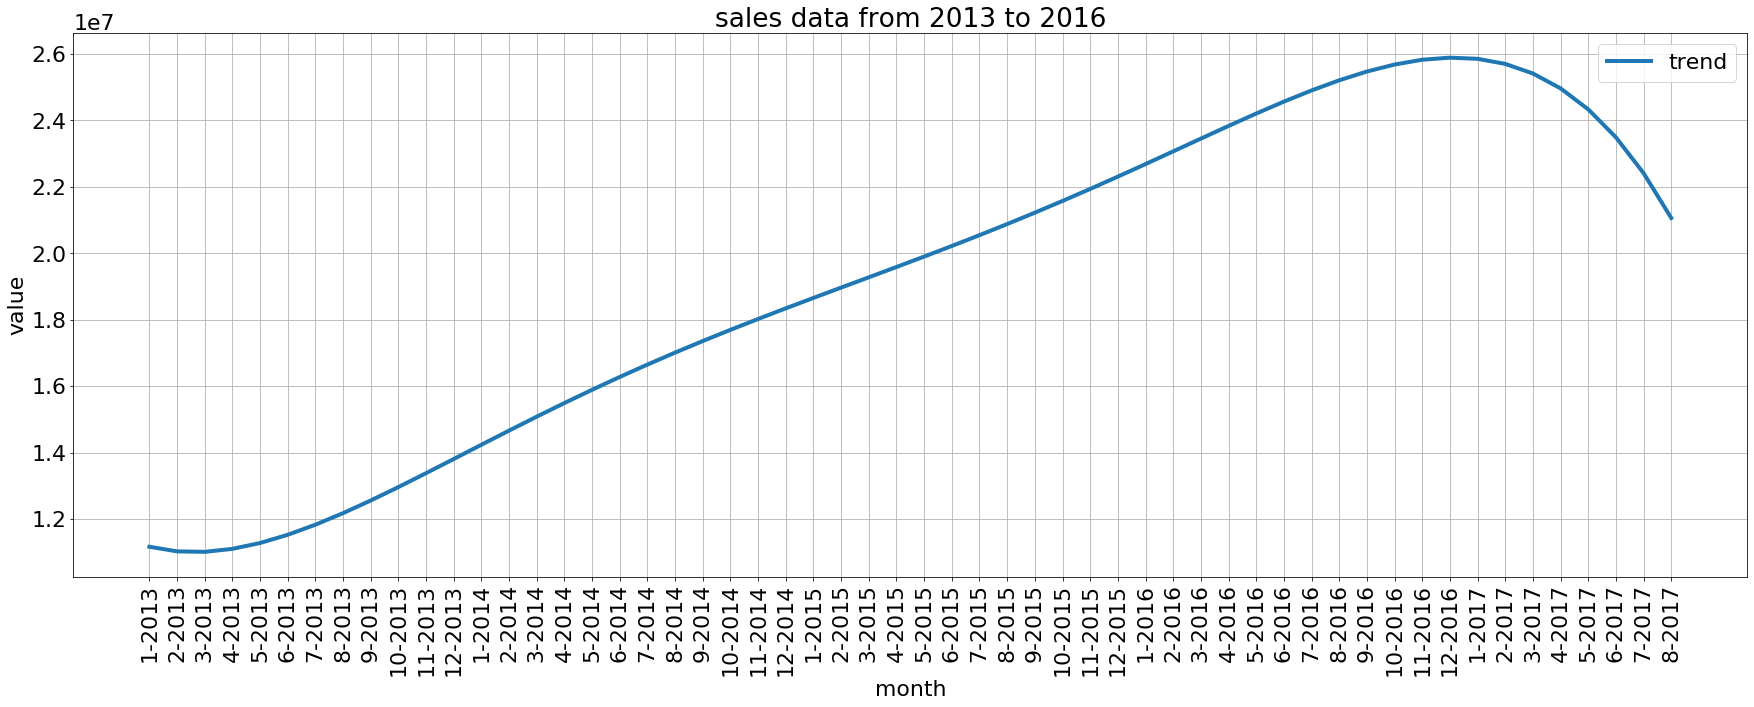

In [29]:

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.trend, marker='', linestyle='-', label='trend', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [30]:
# Find the residual
data['residual'] = data.timeseries - data.trend - data.seasonal


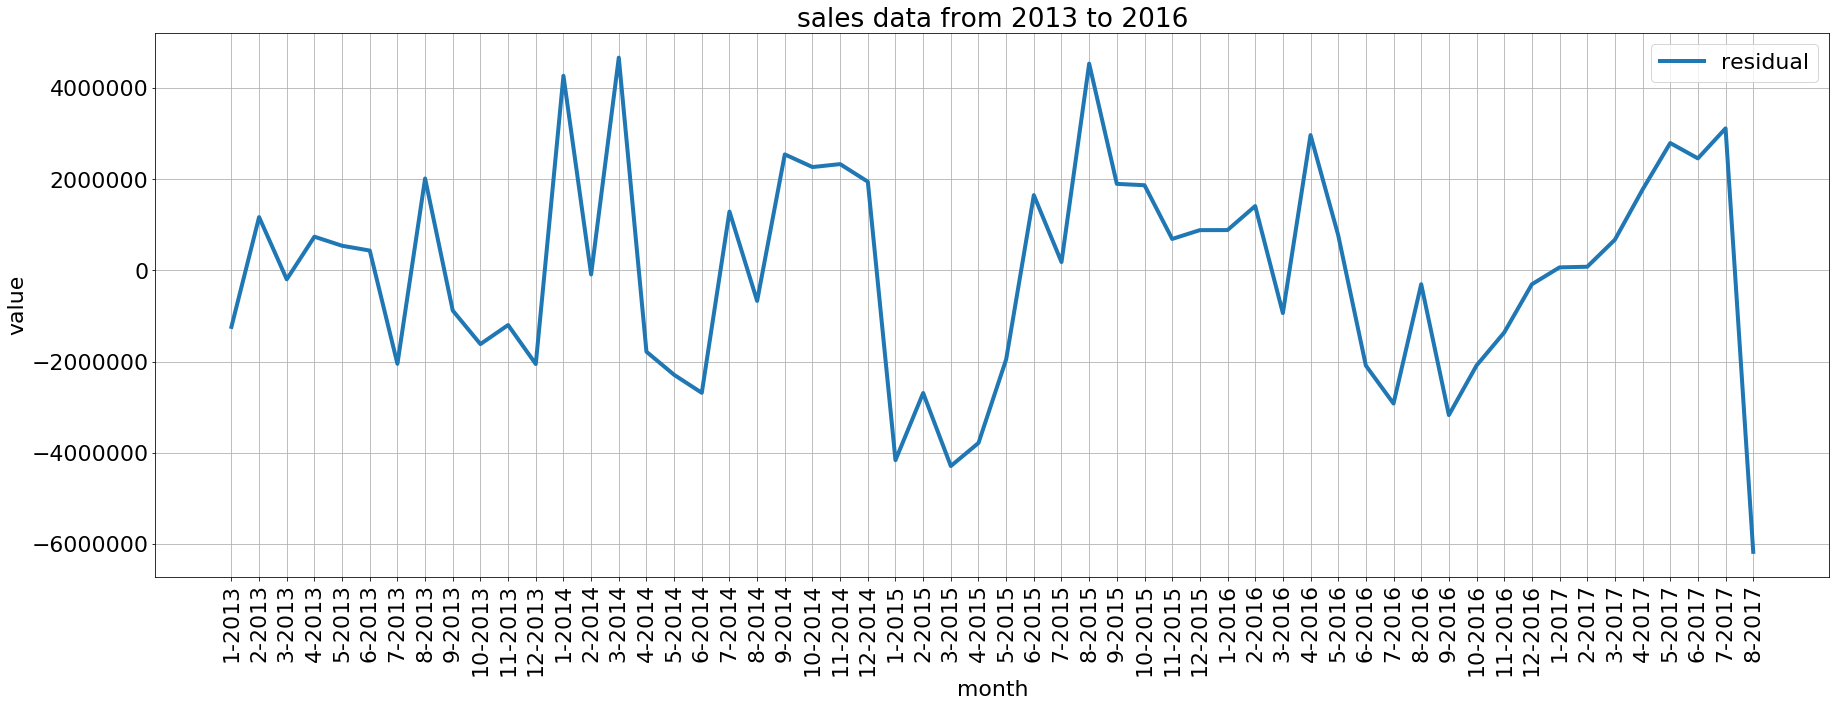

In [31]:

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.residual, marker='', linestyle='-', label='residual', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()


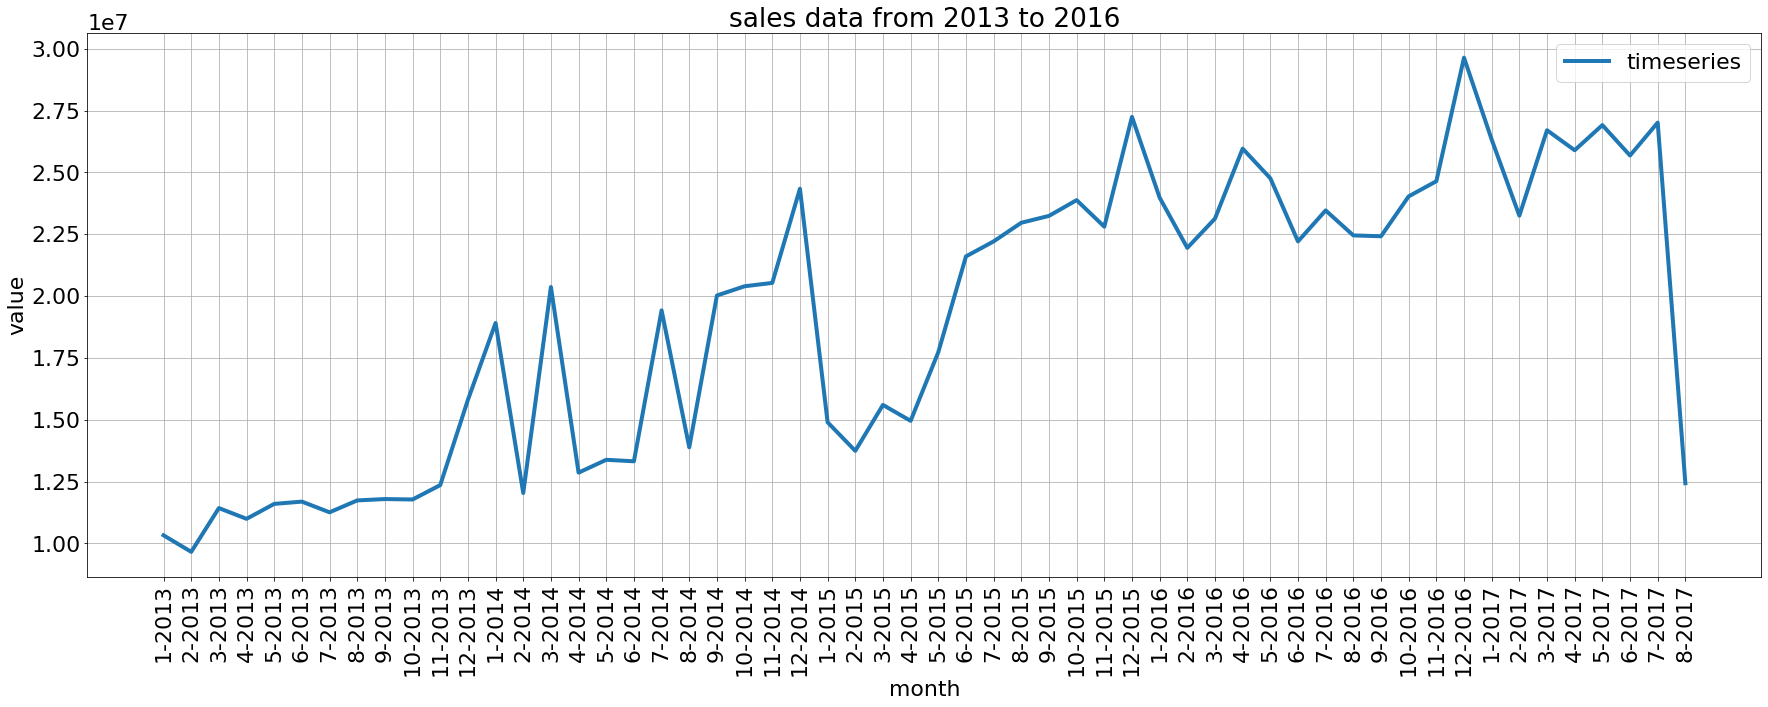

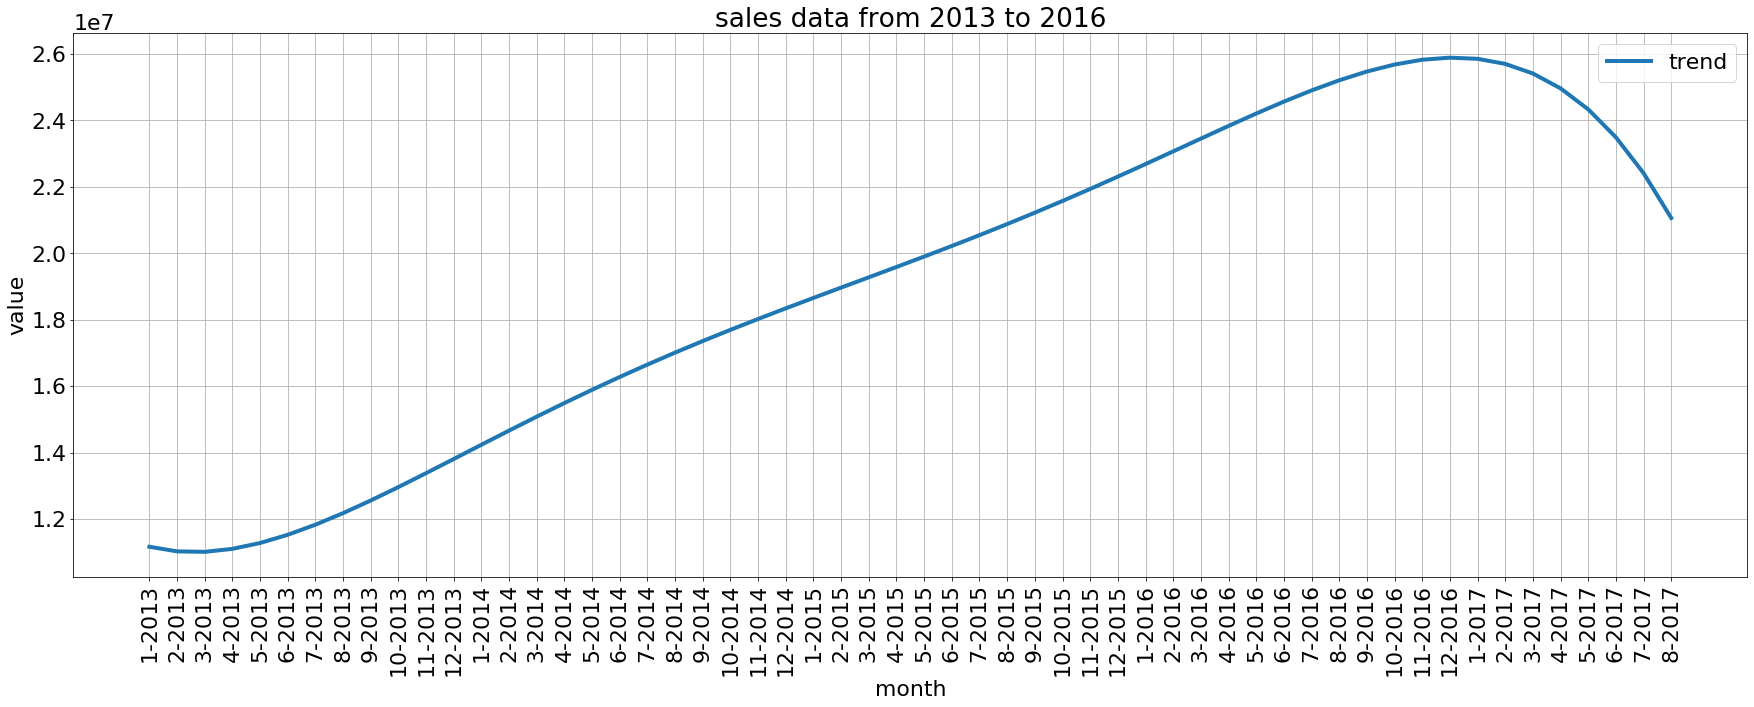

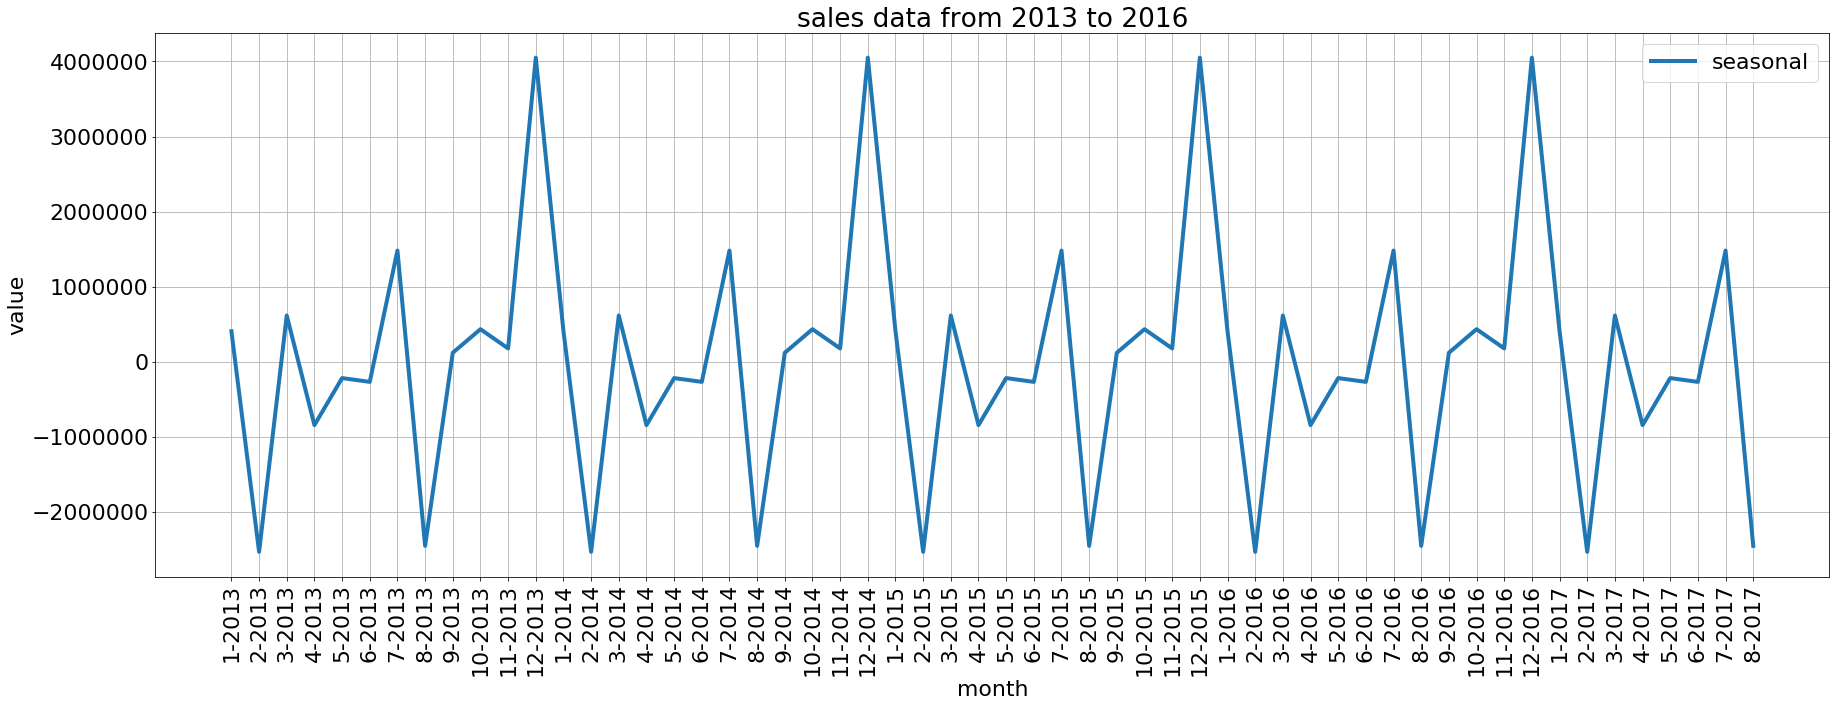

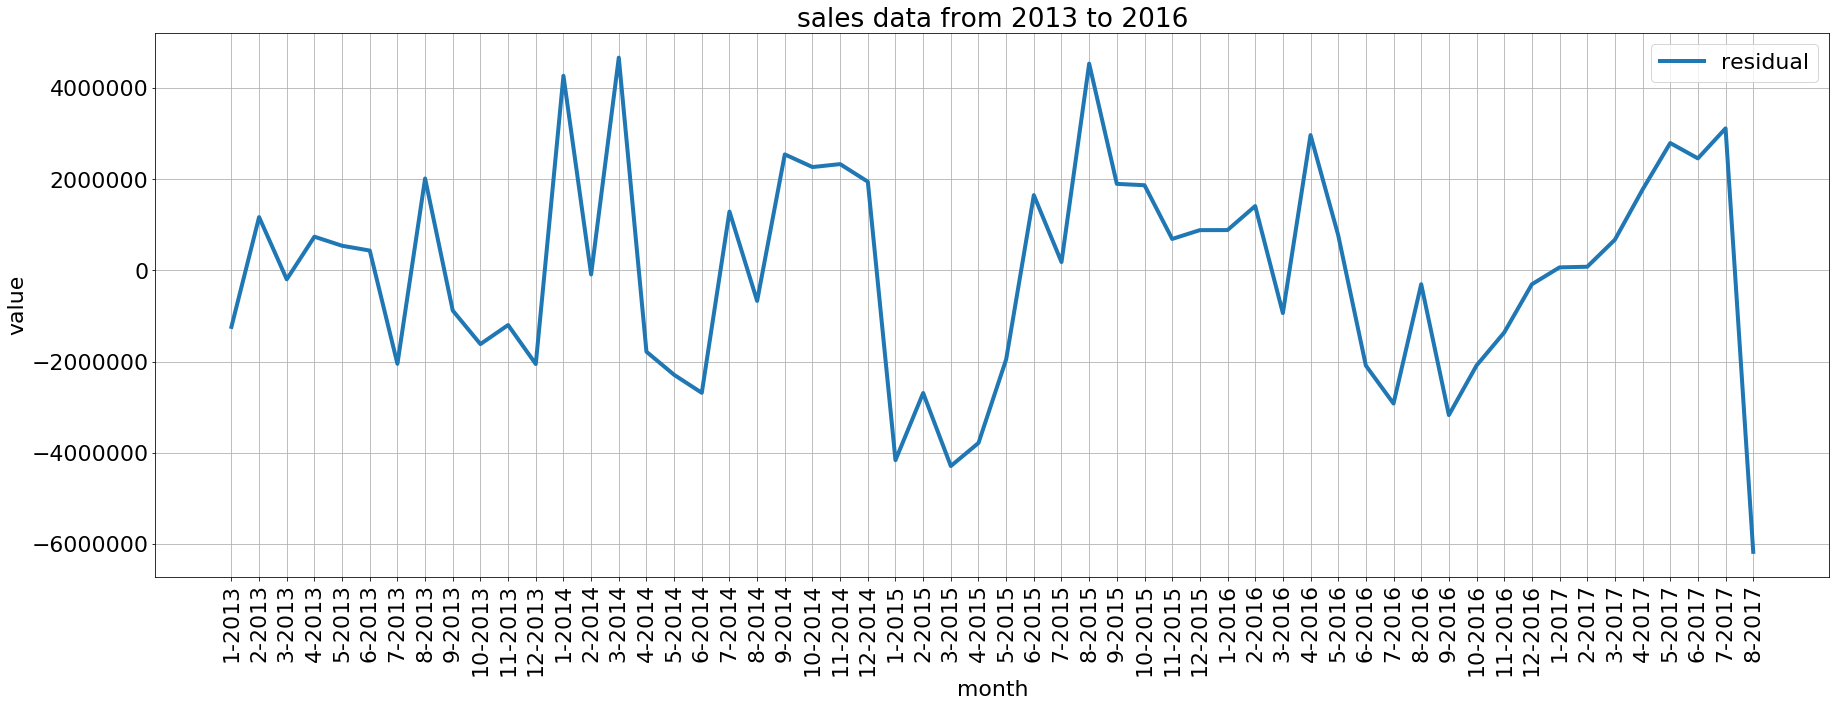

In [32]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.timeseries, marker='', linestyle='-', label='timeseries', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.trend, marker='', linestyle='-', label='trend', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.seasonal, marker='', linestyle='-', label='seasonal', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.residual, marker='', linestyle='-', label='residual', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Statsmodels STL Decompose

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

temp = data.reset_index()
df_stl_month = temp[['index', 'timeseries']].set_index('index')
decomp = seasonal_decompose(df_stl_month.values, period=12)

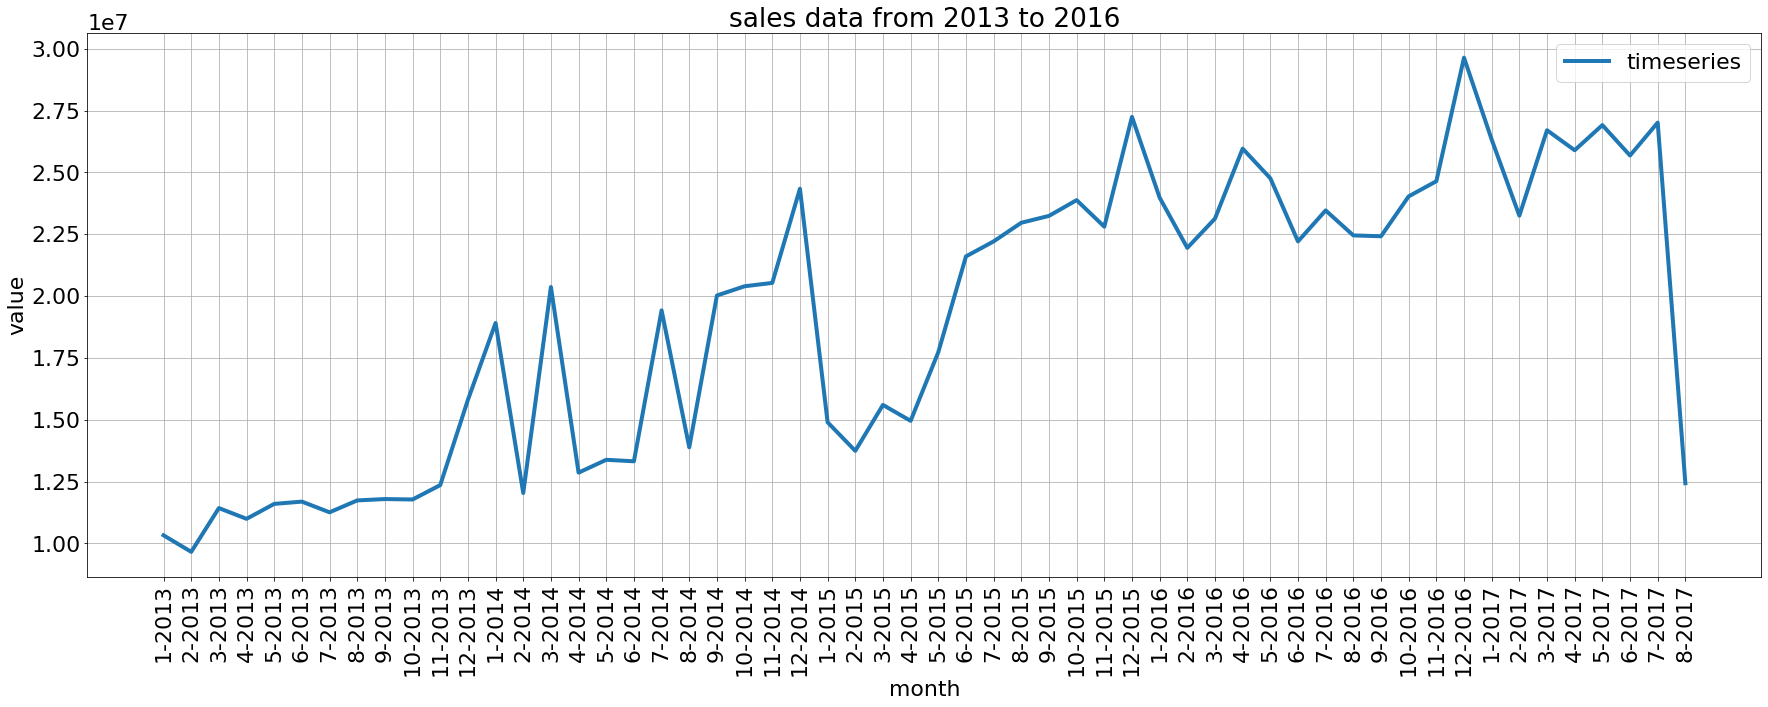

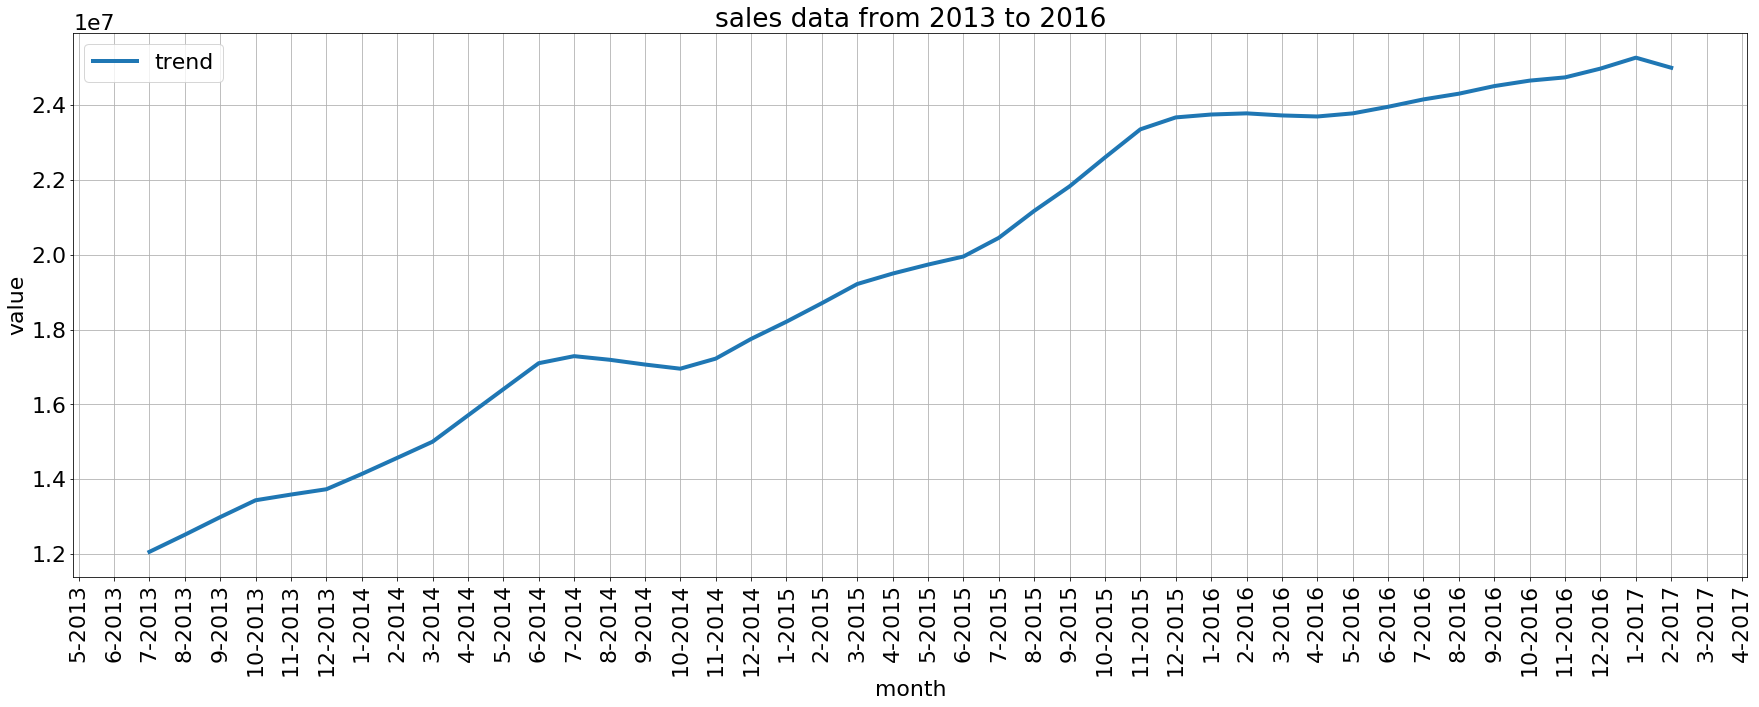

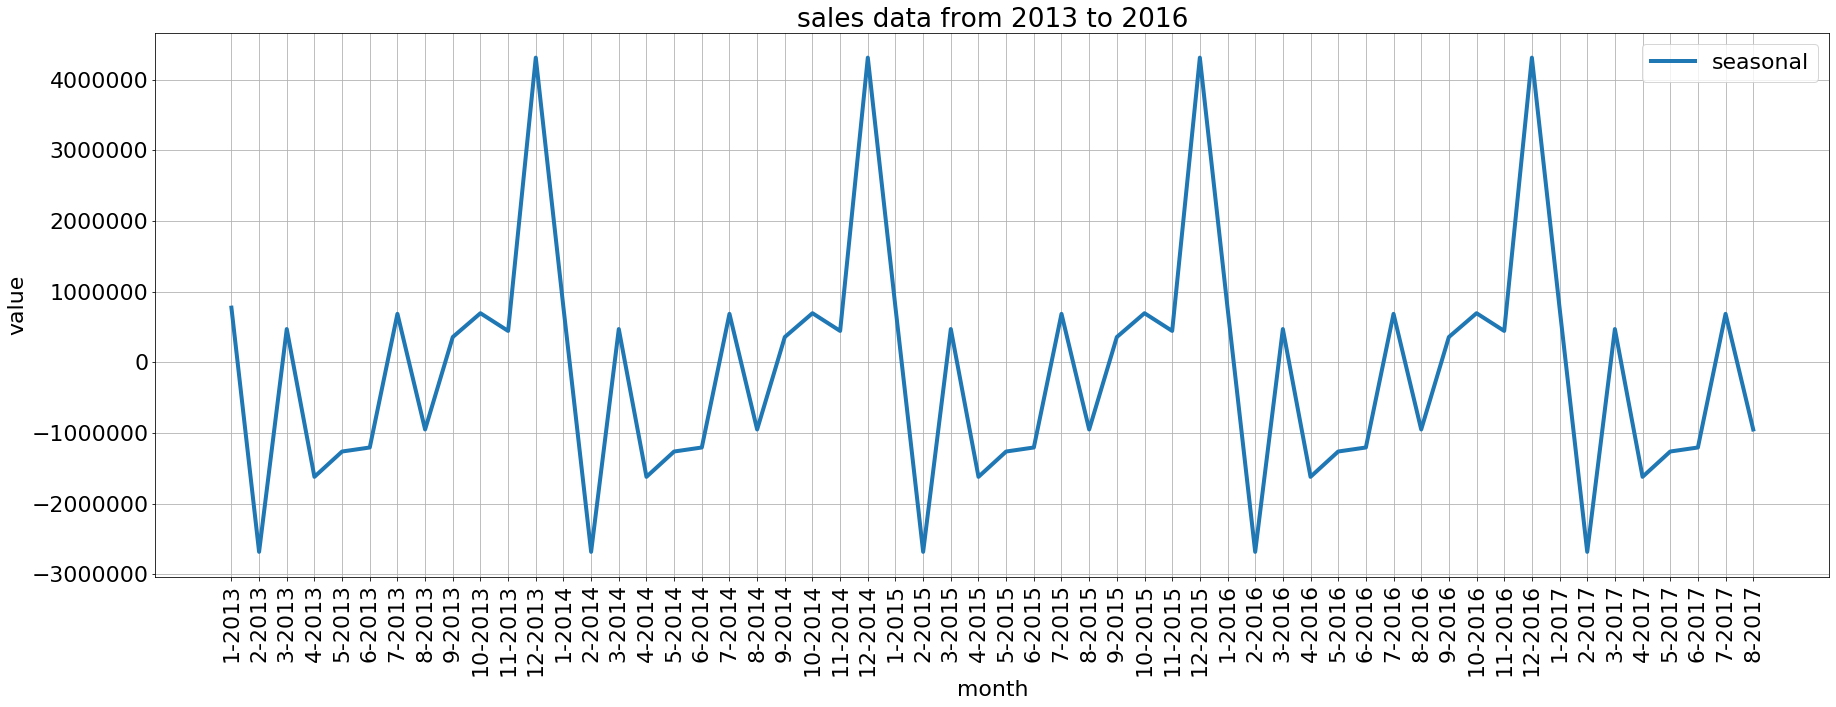

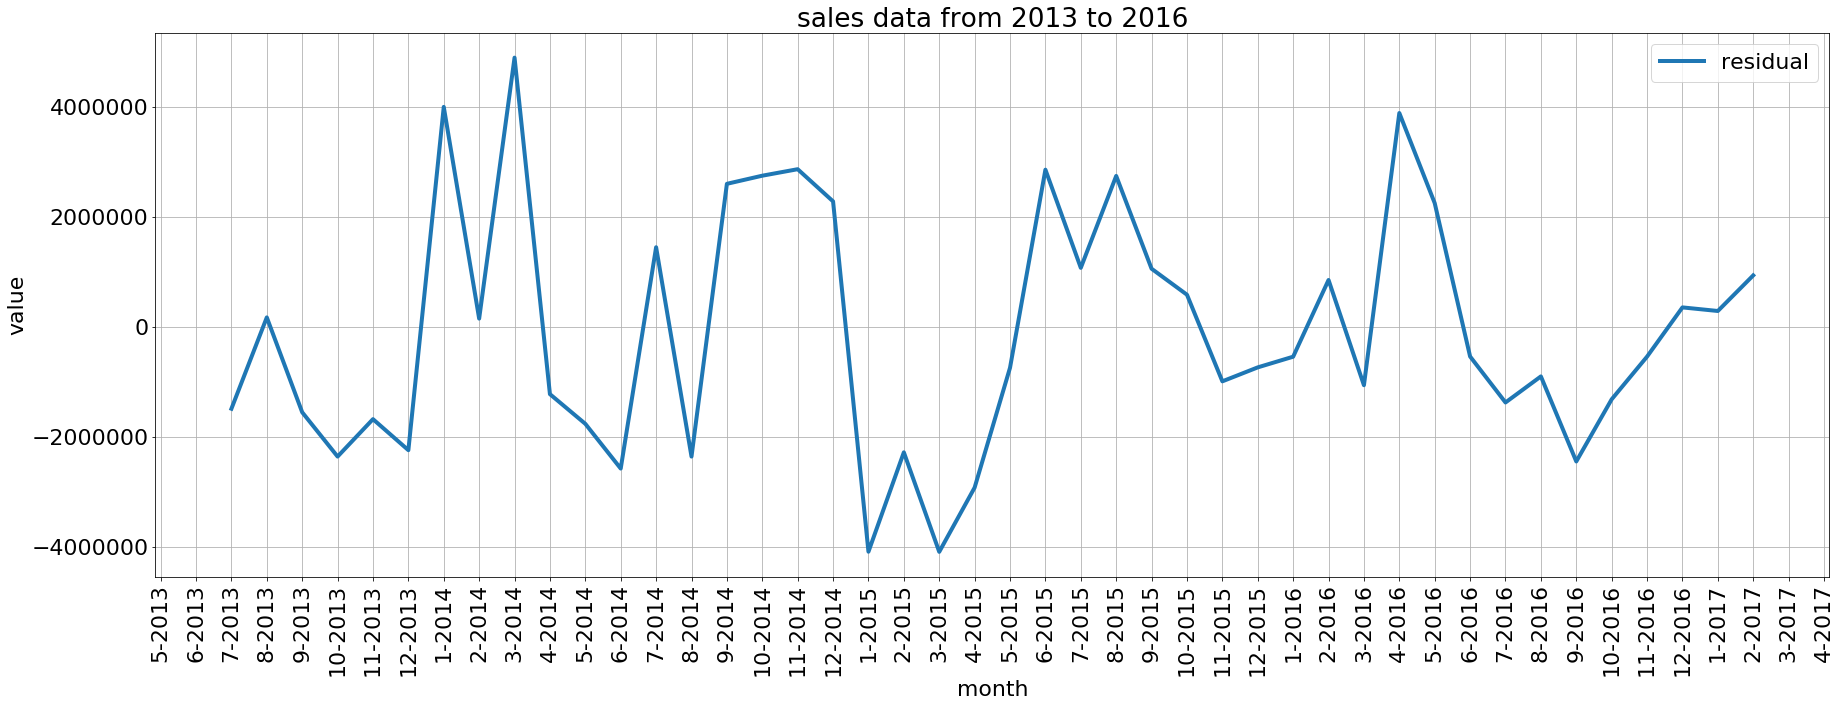

In [34]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, decomp.observed, marker='', linestyle='-', label='timeseries', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, decomp.trend, marker='', linestyle='-', label='trend', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, decomp.seasonal, marker='', linestyle='-', label='seasonal', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, decomp.resid, marker='', linestyle='-', label='residual', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [36]:
data["rolling_median"] = data["residual"].rolling(4).median()
data["rolling_std"] = data["residual"].rolling(6).std()

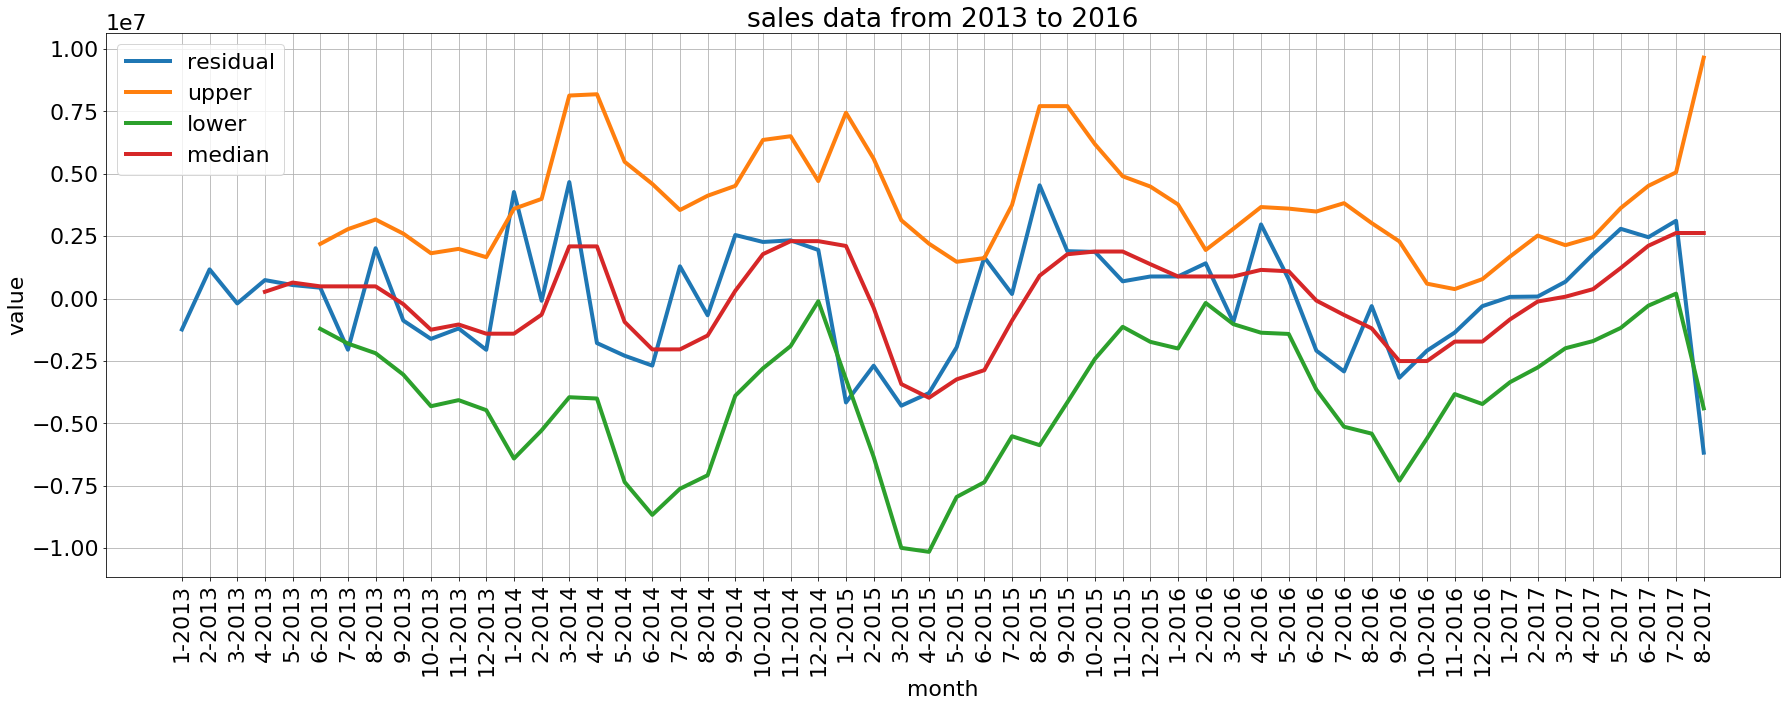

In [37]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.residual, marker='', linestyle='-', label='residual', linewidth=4)
plt.plot(X_index, data.rolling_median + (2 * data["rolling_std"]), marker='', linestyle='-', label='upper', linewidth=4)
plt.plot(X_index, data.rolling_median - (2 * data["rolling_std"]), marker='', linestyle='-', label='lower', linewidth=4)

plt.plot(X_index, data.rolling_median, marker='', linestyle='-', label='median', linewidth=4)

plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

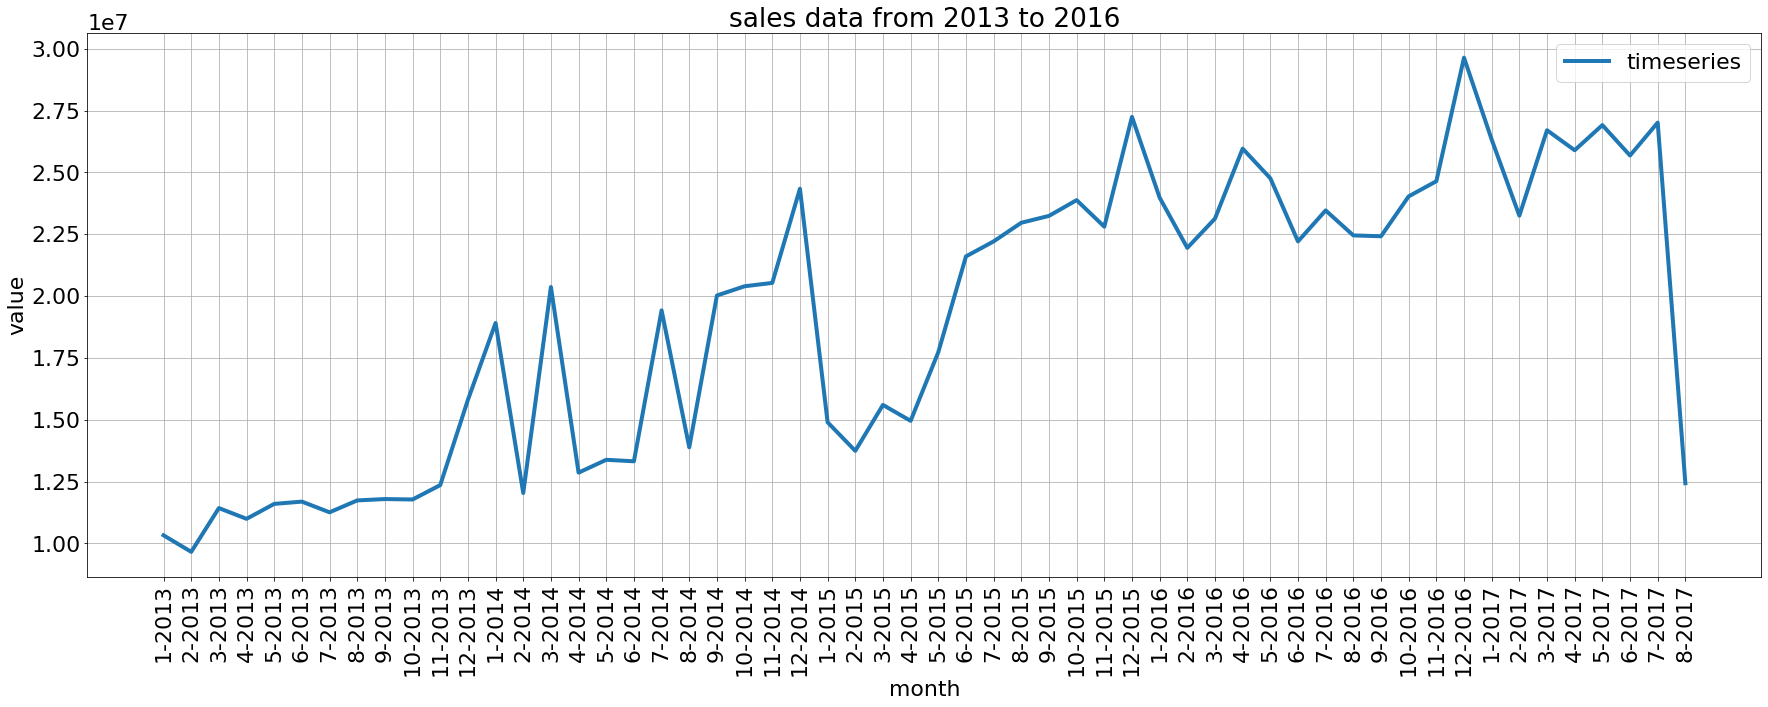

In [38]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, decomp.observed, marker='', linestyle='-', label='timeseries', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [39]:
cond_list, choice_list = [
    (data.residual > (data.rolling_median + (2 * data["rolling_std"]))), 
    (data.residual < (data.rolling_median - (2 * data["rolling_std"])))], [1, 1]
data["outliers"] = np.select(cond_list, choice_list, default=0)
data["outlier_val"] = np.where(data["outliers"] == 1, data.timeseries, None)


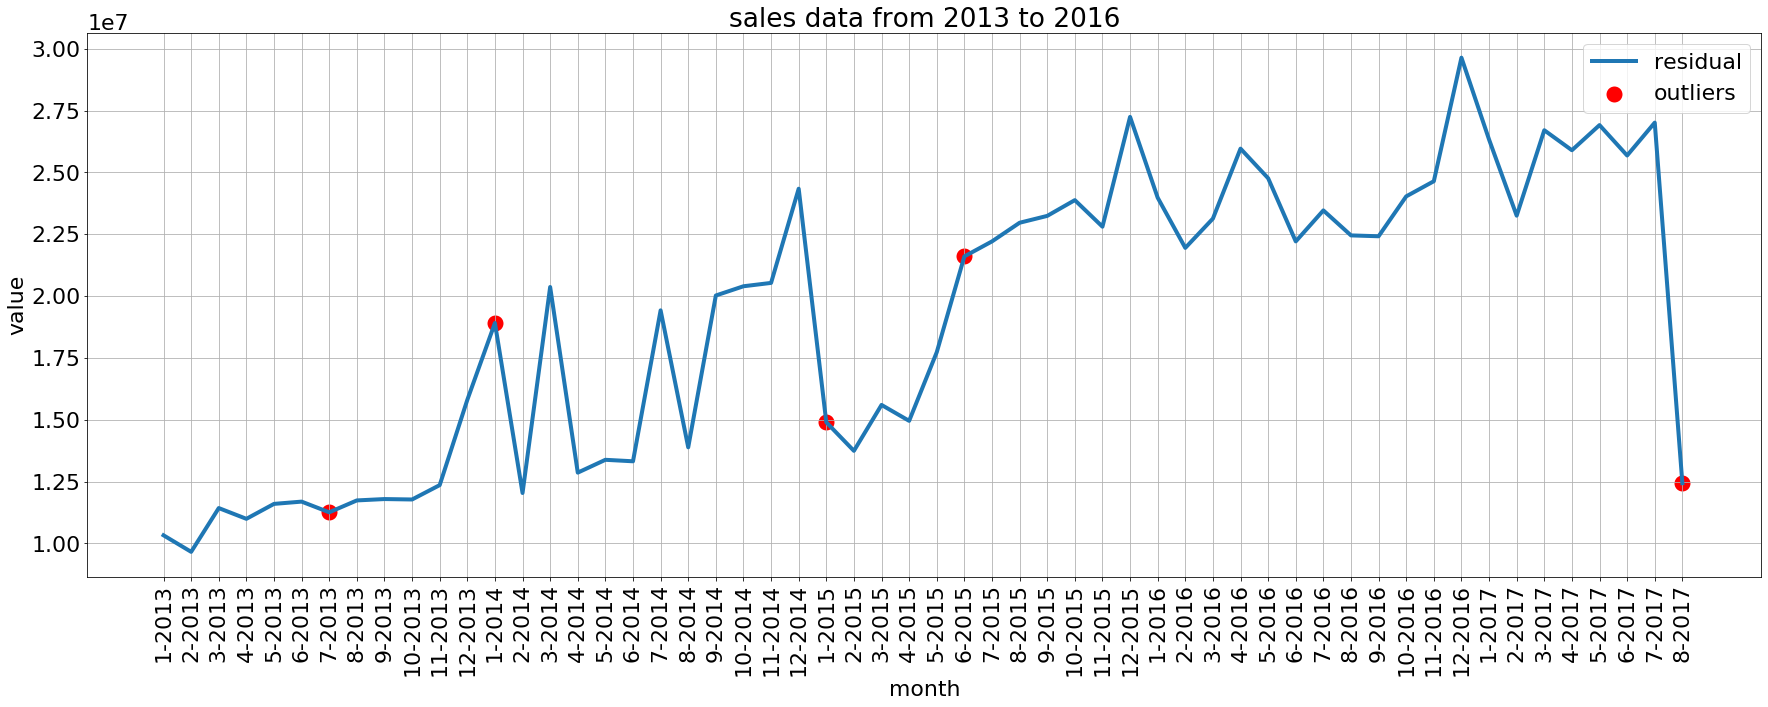

In [40]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.timeseries, marker='', linestyle='-', label='residual', linewidth=4)
plt.scatter(X_index, data.outlier_val, label='outliers', marker="o", color="r", linewidth=10)

plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()